In [1]:
import pickle

USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS   = 950

# Load the pickle file
print("Loading datafile...")
with open("./dataset/mon_standard.pkl", 'rb') as fi: # Path to mon_standard.pkl in Colab
    data = pickle.load(fi)

X_pack_size = [] # Array to store instances (direction*size) - size information
# X_num_pack = [] # Array to store the incoming num of packets
y_m = [] # Array to store the site of each instance - 19,000 instances, e.g., [0, 0, 0, 0, 0, 0, ..., 94, 94, 94, 94, 94]
y_b = []

# Differentiate instances and sites, and store them in the respective x and y arrays
# x array (direction*timestamp), y array (site label)
for i in range(TOTAL_URLS):
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE # Calculate which site's URL the current URL being processed belongs to and set that value as the label. Thus, URLs fetched from the same site are labeled identically.
    for sample in data[i]:
        num_pack = 0
        size_seq = []
        for i, c in enumerate(sample):
            dr = 1 if c > 0 else -1
            size_seq.append(dr * 512)
            # if dr == -1:
            #     num_pack += 1
        X_pack_size.append(size_seq)
        # X_num_pack.append(num_pack)
        y_m.append(label)
        y_b.append(1)

size = len(y_m)

print(f'Total samples: {size}') # Output: 19000


Loading datafile...
Total samples: 19000


In [2]:
TOTAL_URLS = 5000  # total number in the dataset

# Load 10,000 unmon pickle file
print("Loading datafile...")

with open('./dataset/unmon_standard10.pkl', 'rb') as f:  # Path to unmon_standard10.pkl in Colab
  x = pickle.load(f)
size = len(x)
print(f'Total samples: {size}')

for i in range(TOTAL_URLS):
    size_seq = []
    num_pack = 0
    for c in x[i]:
        dr = 1 if c > 0 else -1
        size_seq.append(dr * 512) # In the pickle file, there is no size information, so the conversion code is set to multiply by 512 uniformly.
        # if dr == -1:
        #     num_pack += 1
    X_pack_size.append(size_seq)
    # X_num_pack.append(num_pack)
    y_m.append(-1)
    y_b.append(-1)

print(len(X_pack_size)) # Print the length of X1

Loading datafile...
Total samples: 10000
24000


In [3]:
max_length = max(len(arr) for arr in X_pack_size)

# 각 배열의 길이를 최대 길이에 맞춰 늘리고 부족한 부분은 0으로 채웁니다.
def pad_sequence(sequence, max_length):
    return sequence + [0] * (max_length - len(sequence))

X_pack_size_padded = [pad_sequence(arr, max_length) for arr in X_pack_size]

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# 배열로 변환
X_pack_size_array = np.array(X_pack_size_padded)
# X_num_pack_array = np.array(X_num_pack).reshape(-1, 1)
# X_all = np.concatenate((X_pack_size_array, X_num_pack_array), axis=1)

# 데이터를 학습 및 테스트 세트로 나눔
X_train_pack_size_b, X_test_pack_size_b, y_train_pack_size_b, y_test_pack_size_b = train_test_split(X_pack_size_array, y_b, test_size=0.2, random_state=42)
X_train_pack_size_m, X_test_pack_size_m, y_train_pack_size_m, y_test_pack_size_m = train_test_split(X_pack_size_array, y_m, test_size=0.2, random_state=42)
# X_train_num_pack_m, X_test_num_pack_m, y_train_num_pack_m, y_test_num_pack_m = train_test_split(X_num_pack_array, y_m, test_size=0.2, random_state=42)
# X_train_num_pack_b, X_test_num_pack_b, y_train_num_pack_b, y_test_num_pack_b = train_test_split(X_num_pack_array, y_b, test_size=0.2, random_state=42)
# X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y, test_size=0.2, random_state=42)

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

Binary True Positive Rate: 0.9997916666666666
Binary False Positive Rate: 0.0002083333333333659
Binary Precision: 0.9997916666666666


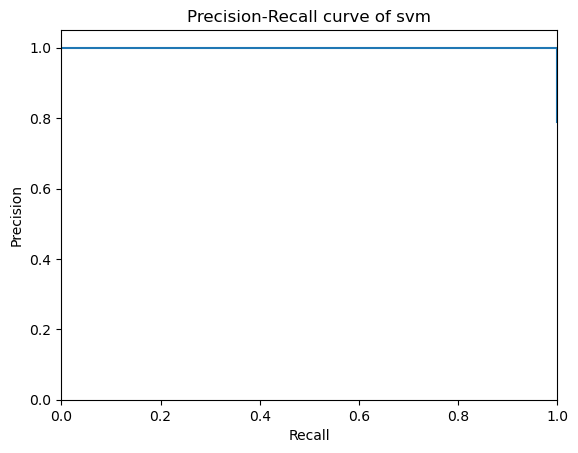

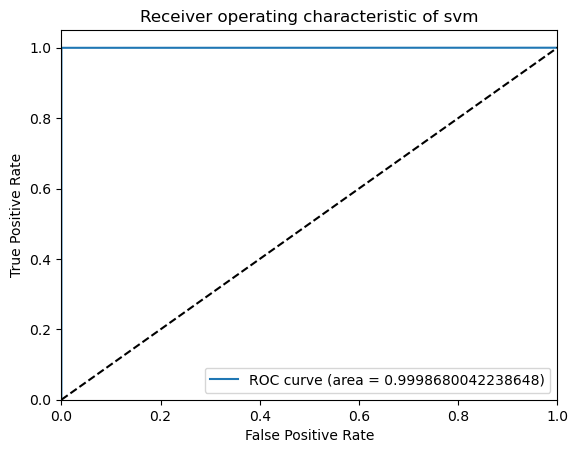

Multi True Positive Rate: 0.7877083333333333
Multi False Positive Rate: 0.21229166666666666
Multi Precision: 0.7877083333333333


In [6]:
svm_model_b = SVC(kernel='linear', C=1.0, random_state=42)
svm_model_b.fit(X_train_pack_size_b, y_train_pack_size_b)
y_pred_svm_b = svm_model_b.predict(X_test_pack_size_b)
tpr_b = recall_score(y_test_pack_size_b, y_pred_svm_b, average='micro')
precision_b = precision_score(y_test_pack_size_b, y_pred_svm_b, average='micro')
print(f'Binary True Positive Rate: {tpr_b}')
print(f'Binary False Positive Rate: {1 - tpr_b}')
print(f'Binary Precision: {precision_b}')

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_pack_size_b, y_pred_svm_b)
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall curve of svm')
plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_test_pack_size_b, y_pred_svm_b)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver operating characteristic of svm')
plt.legend(loc="lower right")
plt.show()

svm_model_m = SVC(kernel='linear', C=1.0, random_state=42)
svm_model_m.fit(X_train_pack_size_m, y_train_pack_size_m)
y_pred_svm_m = svm_model_m.predict(X_test_pack_size_m)
tpr_m = recall_score(y_test_pack_size_m, y_pred_svm_m, average='micro')
precision_m = precision_score(y_test_pack_size_m, y_pred_svm_m, average='micro')
print(f'Multi True Positive Rate: {tpr_m}')
print(f'Multi False Positive Rate: {1 - tpr_m}')
print(f'Multi Precision: {precision_m}')


In [7]:
# svm_model = SVC(kernel='linear', C=1.0, random_state=42)
# svm_model.fit(X_train_num_pack_b, y_train_num_pack_b)
# y_pred_svm_b = svm_model.predict(X_test_num_pack_b)
# tpr_b = recall_score(y_test_num_pack_b, y_pred_svm_b, average='micro')
# precision_b = precision_score(y_test_num_pack_b, y_pred_svm_b, average='micro')
# print(f'Binary True Positive Rate: {tpr_b}')
# print(f'Binary False Positive Rate: {1 - tpr_b}')
# print(f'Binary Precision: {precision_b}')
#
# svm_model = SVC(kernel='linear', C=1.0, random_state=42)
# svm_model.fit(X_train_num_pack_m, y_train_num_pack_m)
# y_pred_svm_m = svm_model.predict(X_test_num_pack_m)
# tpr_m = recall_score(y_test_num_pack_m, y_pred_svm_m, average='micro')
# precision_m = precision_score(y_test_num_pack_m, y_pred_svm_m, average='micro')
# print(f'Multi True Positive Rate: {tpr_m}')
# print(f'Multi False Positive Rate: {1 - tpr_m}')
# print(f'Multi Precision: {precision_m}')

Binary True Positive Rate: 0.9577083333333334
Binary False Positive Rate: 0.042291666666666616
Binary Precision: 0.9577083333333334


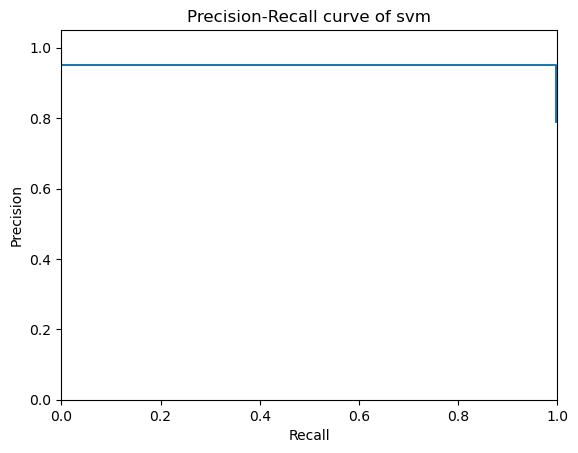

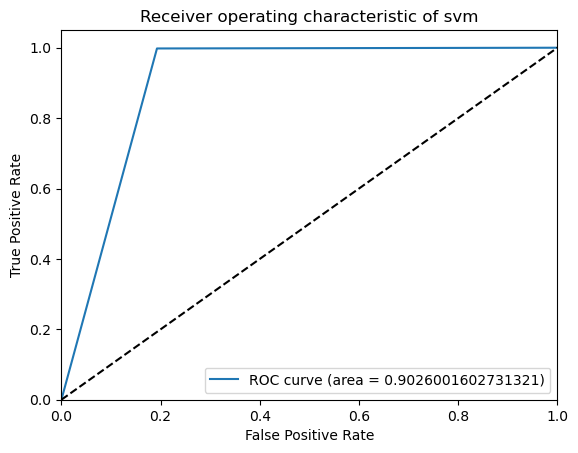

Multi True Positive Rate: 0.53875
Multi False Positive Rate: 0.46125000000000005
Multi Precision: 0.53875


In [8]:
rf_model_b = RandomForestClassifier(n_estimators=20, criterion="entropy", random_state=1)
rf_model_b.fit(X_train_pack_size_b, y_train_pack_size_b)
y_pred_rf_b = rf_model_b.predict(X_test_pack_size_b)
tpr_b = recall_score(y_test_pack_size_b, y_pred_rf_b, average='micro')
precision_b = precision_score(y_test_pack_size_b, y_pred_rf_b, average='micro')
print(f'Binary True Positive Rate: {tpr_b}')
print(f'Binary False Positive Rate: {1 - tpr_b}')
print(f'Binary Precision: {precision_b}')

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_pack_size_b, y_pred_rf_b)
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall curve of svm')
plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_test_pack_size_b, y_pred_rf_b)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver operating characteristic of svm')
plt.legend(loc="lower right")
plt.show()

rf_model_m = RandomForestClassifier(n_estimators=20, criterion="entropy", random_state=1)
rf_model_m.fit(X_train_pack_size_m, y_train_pack_size_m)
y_pred_rf_m = rf_model_m.predict(X_test_pack_size_m)
tpr_m = recall_score(y_test_pack_size_m, y_pred_rf_m, average='micro')
precision_m = precision_score(y_test_pack_size_m, y_pred_rf_m, average='micro')
print(f'Multi True Positive Rate: {tpr_m}')
print(f'Multi False Positive Rate: {1 - tpr_m}')
print(f'Multi Precision: {precision_m}')


In [9]:
# rf_model = RandomForestClassifier(n_estimators=20, criterion="entropy", random_state=1)
# rf_model.fit(X_train_num_pack_b, y_train_num_pack_b)
# y_pred_rf_b = rf_model.predict(X_test_num_pack_b)
# tpr_b = recall_score(y_test_num_pack_b, y_pred_rf_b, average='micro')
# precision_b = precision_score(y_test_num_pack_b, y_pred_rf_b, average='micro')
# print(f'Binary True Positive Rate: {tpr_b}')
# print(f'Binary False Positive Rate: {1 - tpr_b}')
# print(f'Binary Precision: {precision_b}')
#
# rf_model = RandomForestClassifier(n_estimators=20, criterion="entropy", random_state=1)
# rf_model.fit(X_train_num_pack_m, y_train_num_pack_m)
# y_pred_rf_m = rf_model.predict(X_test_num_pack_m)
# tpr_m = recall_score(y_test_num_pack_m, y_pred_rf_m, average='micro')
# precision_m = precision_score(y_test_num_pack_m, y_pred_rf_m, average='micro')
# print(f'Multi True Positive Rate: {tpr_m}')
# print(f'Multi False Positive Rate: {1 - tpr_m}')
# print(f'Multi Precision: {precision_m}')

Binary True Positive Rate: 0.7727083333333333
Binary False Positive Rate: 0.22729166666666667
Binary Precision: 0.7727083333333333


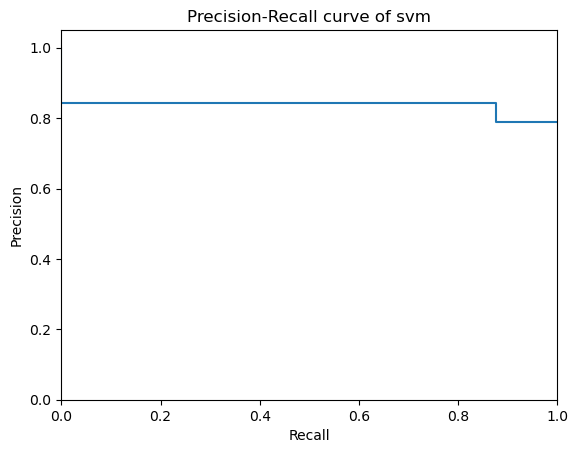

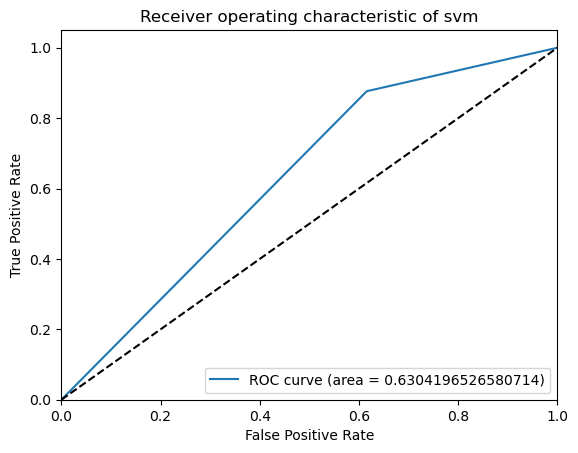

Multi True Positive Rate: 0.2627083333333333
Multi False Positive Rate: 0.7372916666666667
Multi Precision: 0.2627083333333333


In [10]:
knn_model_b = KNeighborsClassifier(n_neighbors=5)
knn_model_b.fit(X_train_pack_size_b, y_train_pack_size_b)
y_pred_knn_b = knn_model_b.predict(X_test_pack_size_b)
tpr_b = recall_score(y_test_pack_size_b, y_pred_knn_b, average='micro')
precision_b = precision_score(y_test_pack_size_b, y_pred_knn_b, average='micro')
print(f'Binary True Positive Rate: {tpr_b}')
print(f'Binary False Positive Rate: {1 - tpr_b}')
print(f'Binary Precision: {precision_b}')

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_pack_size_b, y_pred_knn_b)
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall curve of svm')
plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_test_pack_size_b, y_pred_knn_b)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver operating characteristic of svm')
plt.legend(loc="lower right")
plt.show()

knn_model_m = KNeighborsClassifier(n_neighbors=5)
knn_model_m.fit(X_train_pack_size_m, y_train_pack_size_m)
y_pred_knn_m = knn_model_m.predict(X_test_pack_size_m)
tpr_m = recall_score(y_test_pack_size_m, y_pred_knn_m, average='micro')
precision_m = precision_score(y_test_pack_size_m, y_pred_knn_m, average='micro')
print(f'Multi True Positive Rate: {tpr_m}')
print(f'Multi False Positive Rate: {1 - tpr_m}')
print(f'Multi Precision: {precision_m}')

In [11]:
# knn_model = KNeighborsClassifier(n_neighbors=5)
# knn_model.fit(X_train_num_pack_b, y_train_num_pack_b)
# y_pred_knn_b = knn_model.predict(X_test_num_pack_b)
# tpr_b = recall_score(y_test_num_pack_b, y_pred_knn_b, average='micro')
# precision_b = precision_score(y_test_num_pack_b, y_pred_knn_b, average='micro')
# print(f'Binary True Positive Rate: {tpr_b}')
# print(f'Binary False Positive Rate: {1 - tpr_b}')
# print(f'Binary Precision: {precision_b}')
#
# knn_model = KNeighborsClassifier(n_neighbors=5)
# knn_model.fit(X_train_num_pack_m, y_train_num_pack_m)
# y_pred_knn_m = knn_model.predict(X_test_num_pack_m)
# tpr_m = recall_score(y_test_num_pack_m, y_pred_knn_m, average='micro')
# precision_m = precision_score(y_test_num_pack_m, y_pred_knn_m, average='micro')
# print(f'Multi True Positive Rate: {tpr_m}')
# print(f'Multi False Positive Rate: {1 - tpr_m}')
# print(f'Multi Precision: {precision_m}')

In [12]:
# Hyperparameter tuning with GridSearchCV
param_grid = {'n_estimators': [20, 50, 100, 200], 'criterion': ['gini', 'entropy']}
grid_search = GridSearchCV(rf_model_b, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_pack_size_b, y_train_pack_size_b)

best_params_rf_b = grid_search.best_params_
best_model_rf_b = grid_search.best_estimator_
y_pred_tuned_rf_b = best_model_rf_b.predict(X_test_pack_size_b)
accuracy_tuned_rf_b = accuracy_score(y_test_pack_size_b, y_pred_tuned_rf_b)
print("Best Parameters:", best_params_rf_b)
print("Tuned Model Accuracy:", accuracy_tuned_rf_b)

# Hyperparameter tuning with GridSearchCV
grid_search = GridSearchCV(rf_model_m, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_pack_size_m, y_train_pack_size_m)

best_params_rf_m = grid_search.best_params_
best_model_rf_m = grid_search.best_estimator_
y_pred_tuned_rf_m = best_model_rf_m.predict(X_test_pack_size_m)
accuracy_tuned_rf_m = accuracy_score(y_test_pack_size_m, y_pred_tuned_rf_m)
print("Best Parameters:", best_params_rf_m)
print("Tuned Model Accuracy:", accuracy_tuned_rf_m)

Best Parameters: {'criterion': 'gini', 'n_estimators': 100}
Tuned Model Accuracy: 0.9685416666666666
Best Parameters: {'criterion': 'gini', 'n_estimators': 200}
Tuned Model Accuracy: 0.69375


In [ ]:
# Hyperparameter tuning with GridSearchCV
param_grid = {'C': [1, 10, 100],
              'gamma': ['scale'],
              'kernel': ['rbf']}
grid_search = GridSearchCV(svm_model_b, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_pack_size_b, y_train_pack_size_b)

best_params_svm_b = grid_search.best_params_
best_model_svm_b = grid_search.best_estimator_
y_pred_tuned_svm_b = best_model_svm_b.predict(X_test_pack_size_b)
accuracy_tuned_svm_b = accuracy_score(y_test_pack_size_b, y_pred_tuned_svm_b)
print("Best Parameters:", best_model_svm_b)
print("Tuned Model Accuracy:", accuracy_tuned_svm_b)

grid_search = GridSearchCV(svm_model_m, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_pack_size_m, y_train_pack_size_m)

best_params_svm_m = grid_search.best_params_
best_model_svm_m = grid_search.best_estimator_
y_pred_tuned_svm_m = best_model_svm_m.predict(X_test_pack_size_m)
accuracy_tuned_svm_m = accuracy_score(y_test_pack_size_m, y_pred_tuned_svm_m)
print("Best Parameters:", best_model_svm_m)
print("Tuned Model Accuracy:", accuracy_tuned_svm_m)

Best Parameters: SVC(C=10, random_state=42)
Tuned Model Accuracy: 0.995625
